In [8]:
# general utilities for openfile

import numpy as np
from numba import njit, cuda, float32

@njit
def jit_inv(A):
    return np.linalg.inv(A)

@njit
def jit_linsolve(A, b):
    return np.linalg.solve(A, b)

@njit(parallel=True)
def jit_paralinsolve(A, b):
    return np.linalg.solve(A, b)

@njit
def jit_lineig(A):
    return np.linalg.eigh(A)


c:\Users\gmme\svc\openpile\.venv\lib\site-packages\numba\core\typed_passes.py:330: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "..\..\AppData\Local\Temp\ipykernel_288192\2980702504.py", line 14:
<source missing, REPL/exec in use?>

  state.func_ir.loc))


Text(0, 0.5, 'Result from timeit [s]')

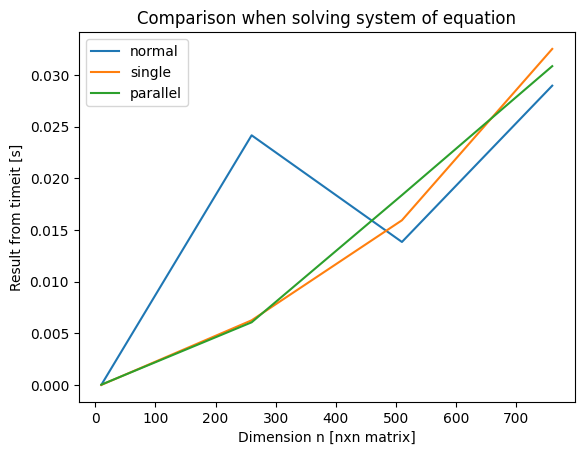

In [ ]:
#system of eq
single_result = []
para_result = []
normal_result =[]
dim = []
for n in range(10,1010,250):
    A = np.random.rand(n,n)
    b = np.random.rand(n,1)
    res = %timeit -o -q -r 3 np.linalg.solve(A,b)
    normal_result.append(np.mean(res.timings))
    res = %timeit -o -q -r 3 jit_paralinsolve(A,b)
    para_result.append(np.mean(res.timings))
    res = %timeit -o -q -r 3 jit_linsolve(A,b)
    single_result.append(np.mean(res.timings))
    dim.append(n)
    
import matplotlib.pyplot as plt

plt.plot(dim,normal_result,dim,single_result,dim,para_result)
plt.title('Comparison when solving system of equation')
plt.legend(['normal','single','parallel'])
plt.xlabel('Dimension n [nxn matrix]')
plt.ylabel('Result from timeit [s]')

In [16]:
#system of eq
single_result = []
para_result = []
normal_result =[]
dim = []
for n in range(10,1010,250):
    A = np.random.rand(n,n)
    b = np.random.rand(n,1)
    res = %timeit -o -q -r 3 np.linalg.solve(A,b)
    normal_result.append(np.mean(res.timings))
    res = %timeit -o -q -r 3 jit_paralinsolve(A,b)
    para_result.append(np.mean(res.timings))
    res = %timeit -o -q -r 3 jit_linsolve(A,b)
    single_result.append(np.mean(res.timings))
    dim.append(n)
    
import matplotlib.pyplot as plt

plt.plot(dim,normal_result,dim,single_result,dim,para_result)
plt.title('Comparison when solving system of equation')
plt.legend(['normal','single','parallel'])
plt.xlabel('Dimension n [nxn matrix]')
plt.ylabel('Result from timeit [s]')

NameError: name 'jit_paralinsolve' is not defined

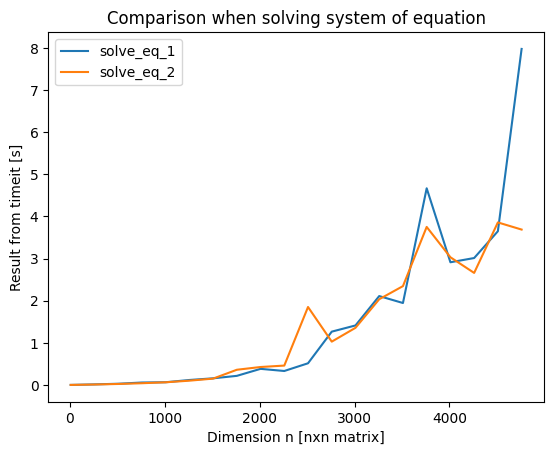

In [87]:
# general utilities for openfile

import numpy as np
from numba import njit, cuda, float32

@njit
def jit_solve(A, b):
    return np.linalg.solve(A, b)

@njit
def njit_matmul(a, b):
    ra, ca = a.shape
    if ra == None:
        a.reshape(1,-1)
    elif ca == None:
        a.reshape(-1,1)
    rb, cb = b.shape
    if rb == None:
        b.reshape(1,-1)
    elif cb == None:
        b.reshape(-1,1)
           
    output = np.zeros(shape=(ra, cb))
    for i in range(ra):
        for j in range(cb):
            for k in range(rb):
                output[i, j] += a[i, k] * b[k, j]
                
    return output

@njit
def numba_ix(arr, rows, cols):
    """
    Numba compatible implementation of arr[np.ix_(rows, cols)] for 2D arrays.
    :param arr: 2D array to be indexed
    :param rows: Row indices
    :param cols: Column indices
    :return: 2D array with the given rows and columns of the input array
    """
    one_d_index = np.zeros(len(rows) * len(cols), dtype=np.int32)
    for i, r in enumerate(rows):
        start = i * len(cols)
        one_d_index[start: start + len(cols)] = cols + arr.shape[1] * r

    arr_1d = arr.reshape((arr.shape[0] * arr.shape[1], 1))
    slice_1d = np.take(arr_1d, one_d_index)
    return slice_1d.reshape((len(rows), len(cols)))

@njit
def jit_dot(a, b):
    return a.dot(b)

@njit
def jit_eigh(A):
    return np.linalg.eigh(A)

@njit
def reverse_indices(A, B):
    return np.array([x for x in A if x not in B])

@njit  
def numba_ix(arr, rows, cols):
    """
    Numba compatible implementation of arr[np.ix_(rows, cols)] for 2D arrays.
    :param arr: 2D array to be indexed
    :param rows: Row indices
    :param cols: Column indices
    :return: 2D array with the given rows and columns of the input array
    """
    one_d_index = np.zeros(len(rows) * len(cols), dtype=np.int32)
    for i, r in enumerate(rows):
        start = i * len(cols)
        one_d_index[start: start + len(cols)] = cols + arr.shape[1] * r

    arr_1d = arr.reshape((arr.shape[0] * arr.shape[1], 1))
    slice_1d = np.take(arr_1d, one_d_index)
    return slice_1d.reshape((len(rows), len(cols)))

def solve_equations(K , F, BC):
    """function that solves the system of equations

    _extended_summary_

    Parameters
    ----------
    K : numpy array
        Global stiffness matrix with all dofs in kPa.
    F : numpy array 
        External force vetor (can also be denoted as load vector) in kN.
    BC : list (of tuples)
        tuples where first item is the prescribed dof, and second item is the precribed displacement in metres.
    """    
    
    if BC:
        prescribed_dof_all = np.arange(len(F))
        prescribed_dof_True =  np.arange(len(BC))
        prescribed_disp = np.zeros([len(BC),1],dtype=float)
        for idx, val in enumerate(BC):
            prescribed_dof_True[idx] = int(val[0])
            prescribed_disp[idx] = val[1]
            
        prescribed_dof_False =  reverse_indices(prescribed_dof_all, prescribed_dof_True)

        u = np.zeros(F.shape,dtype=float)
        u[prescribed_dof_True] = prescribed_disp

        Fred = F[np.ix_(prescribed_dof_False,[0])] - K[np.ix_(prescribed_dof_False,prescribed_dof_True)] @ prescribed_disp 
        Kred = K[np.ix_(prescribed_dof_False,prescribed_dof_False)]

        u[prescribed_dof_False] = jit_solve(Kred,Fred)        
    else:
        u = jit_solve(K,F)
    
    Q = jit_dot(K, u) - F
    
    return u, Q

def solve_equations_fast(K , F, BC):
    """function that solves the system of equations

    _extended_summary_

    Parameters
    ----------
    K : numpy array
        Global stiffness matrix with all dofs in kPa.
    F : numpy array 
        External force vetor (can also be denoted as load vector) in kN.
    BC : list (of tuples)
        tuples where first item is the prescribed dof, and second item is the precribed displacement in metres.
    """    
    
    if BC:
        prescribed_dof_all = np.arange(len(F))
        prescribed_dof_True =  np.arange(len(BC))
        prescribed_disp = np.zeros([len(BC),1],dtype=float)
        for idx, val in enumerate(BC):
            prescribed_dof_True[idx] = int(val[0])
            prescribed_disp[idx] = val[1]
            
        prescribed_dof_False =  reverse_indices(prescribed_dof_all, prescribed_dof_True)

        u = np.zeros(F.shape,dtype=float)
        u[prescribed_dof_True] = prescribed_disp

        Fred = numba_ix(F,prescribed_dof_False,np.array([0])) - numba_ix(K,prescribed_dof_False,prescribed_dof_True) @ prescribed_disp 
        Kred = numba_ix(K, prescribed_dof_False,prescribed_dof_False)

        u[prescribed_dof_False] = jit_solve(Kred,Fred)        
    else:
        u = jit_solve(K,F)
    
    Q = K @ u - F
    
    return u, Q

import numpy as np
import matplotlib.pyplot as plt

#pre-allocate
results_func1 = []
results_func2 =[]
dim = []
for n in range(10,5010,250):
    A = np.random.rand(n,n)
    b = np.random.rand(n,1)
    BC = [
        (1,0),
        (3,0)
    ]
    res = %timeit -o -q -r 7 solve_equations(A,b,BC)
    results_func1.append(np.mean(res.timings))
    res = %timeit -o -q -r 7 solve_equations_fast(A,b,BC)
    results_func2.append(np.mean(res.timings))
    dim.append(n)    

plt.plot(dim,results_func1,dim,results_func2)
plt.title('Comparison when solving system of equation')
plt.legend(['numpy solve eq', 'Openpile with BC'])
plt.xlabel('Dimension n [nxn matrix]')
plt.ylabel('Result from timeit [s]')
plt.legend(['solve_eq_1', 'solve_eq_2'])

In [73]:
import timeit

@njit  # cache=False only for performance comparison
def numba_ix(arr, rows, cols):
    """
    Numba compatible implementation of arr[np.ix_(rows, cols)] for 2D arrays.
    :param arr: 2D array to be indexed
    :param rows: Row indices
    :param cols: Column indices
    :return: 2D array with the given rows and columns of the input array
    """
    one_d_index = np.zeros(len(rows) * len(cols), dtype=np.int32)
    for i, r in enumerate(rows):
        start = i * len(cols)
        one_d_index[start: start + len(cols)] = cols + arr.shape[1] * r

    arr_1d = arr.reshape((arr.shape[0] * arr.shape[1], 1))
    slice_1d = np.take(arr_1d, one_d_index)
    return slice_1d.reshape((len(rows), len(cols)))

def numpy_ix(arr, rows, cols):
    return arr[np.ix_(rows, cols)]


arr = np.random.random((123, 456))

rows = np.array([0, 2, 4, 8, 16, 32, 64])
cols = np.array([1, 3, 9, 27, 81, 243])

a = numpy_ix(arr, rows, cols)
b = numba_ix(arr, rows, cols)

print(np.all(a == b))

n = 1_000_000
print("numpy", timeit.timeit(lambda: numpy_ix(arr, rows, cols), number=n))
print("numba", timeit.timeit(lambda: numba_ix(arr, rows, cols), number=n))



True
numpy 8.721944199991412
numba 2.8537742999906186


In [78]:
cols

array([  1,   3,   9,  27,  81, 243])